In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import bokeh
from bokeh.plotting import figure, output_file, show, ColumnDataSource
# import bokeh.charts.utils
import bokeh.io
import bokeh.models
from bokeh.models import HoverTool
import bokeh.palettes
import bokeh.plotting
import random
from random import sample
from sklearn import svm, neighbors


from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Preprocessing, normalization done in excel (Xnew = (X-mean)/std))
# If we want to normalize in Python we can use preprocessing.scale()
Data = pd.read_csv('songs4.csv')
Data = Data.iloc[:, 0:18]
#Data = Data.drop(Data[(Data.time_signature > 5)].index)
Data.head()

,ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts
0,5CQ30WqJwcep0pYcV4AMNc,-1.268543,-0.885605,1.050276,-0.280775,-1.258128,-0.630077,0.678645,-0.649848,-0.480625,-1.032112,-1.205528,1.347462,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
1,0yE62JSC9J9C4Q4OBMwBgA,-0.385007,-0.303138,1.050276,0.009403,0.794818,2.212337,-0.630163,-0.658555,-0.504163,-0.175880,-0.772431,-0.113739,-0.040332,-0.105962,3.181954,-2.641279,-0.152588
2,66v8ihTuXUDKqienUaFzIe,-1.191040,-0.723399,-0.901086,-0.765659,0.794818,0.067502,-0.499560,-0.658546,-0.357049,-0.255795,1.629569,-0.519527,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
3,6l4HJkk0CwELcf1CgrbAth,1.511236,0.098691,-1.179852,0.430741,0.794818,-0.338460,-0.052175,-0.658555,0.113717,-0.000828,0.370186,-0.701656,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
4,68rPZWbtaNGUh15AVTSlNn,-0.152498,0.330941,-1.179852,0.428633,0.794818,0.561423,-0.893036,-0.658555,-0.527702,-0.274822,0.025924,0.156217,-0.040332,-0.105962,-0.314267,0.378598,-0.152588


In [3]:
# check number of rows
Data.count()

ID                  60342
danceability        60342
energy              60342
key                 60342
loudness            60342
mode                60342
speechiness         60342
acousticness        60342
instrumentalness    60342
liveness            60342
valence             60342
tempo               60342
duration_ms         60342
zero_ts             60342
one_ts              60342
three_ts            60342
four_ts             60342
five_ts             60342
dtype: int64

In [4]:
# Divide into testing and training
x = Data.drop('valence', 1)
y = Data.valence
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20)
train = xtrain
train['valence'] = ytrain
train = train [0: 5000]
train.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts,valence
6308,6HlGEenccWjirZaYUfSSij,1.211557,-0.251527,1.050276,0.473808,-1.258128,-0.569182,0.270164,-0.658555,-0.539471,0.005888,0.079402,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,-0.035077
55845,4UYmECqeFLJ8it4igTGjoU,-1.273710,0.629548,1.050276,0.665804,0.794818,-0.613161,-0.930105,-0.658549,-0.610086,-1.519503,-0.001159,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,-0.545011
38299,79HDcjLmBZCUyUDlsyIzRW,-2.451757,-1.974598,0.492744,-2.151044,0.794818,-0.574595,1.770708,0.617562,-0.772500,-1.792610,-0.004539,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,-1.599890
6652,7aZ2AqSnr45SqNJOIbawWn,-1.862734,1.377908,1.050276,1.011096,0.794818,0.277250,-0.932971,-0.658299,-0.410010,0.535914,-0.330891,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,-1.615112
55789,5SkSa4KcYWKZehf5vvDN06,-0.901695,-0.203602,-0.901086,0.173089,-1.258128,-0.626017,0.520254,-0.657502,-0.521817,-0.405248,0.149888,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,-0.914142


In [5]:
# Create correlation matrix
M = train.corr()

In [6]:
M

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts,valence
danceability,1.000000,0.376361,0.041000,0.446021,-0.084173,0.219166,-0.442442,-0.257240,-0.048310,0.045629,-0.074964,-0.122280,-0.089381,-0.275106,0.313829,-0.075088,0.476387
energy,0.376361,1.000000,0.061422,0.828014,-0.056409,0.118641,-0.749318,-0.308073,0.193608,0.249137,-0.048830,-0.071275,-0.099791,-0.271264,0.301874,-0.063493,0.376433
key,0.041000,0.061422,1.000000,0.046890,-0.183341,0.028074,-0.054903,-0.040083,-0.032433,0.005102,-0.004614,-0.010904,0.005840,-0.013024,0.003568,0.016561,0.056778
loudness,0.446021,0.828014,0.046890,1.000000,-0.039817,0.105198,-0.678627,-0.474478,0.139209,0.213627,-0.104423,-0.052135,-0.102110,-0.263010,0.299478,-0.077940,0.360254
mode,-0.084173,-0.056409,-0.183341,-0.039817,1.000000,-0.035133,0.066565,-0.012639,0.032439,0.027710,0.002595,-0.028563,0.017070,0.056918,-0.035373,-0.034291,-0.009671
speechiness,0.219166,0.118641,0.028074,0.105198,-0.035133,1.000000,-0.081879,-0.266697,0.184552,0.025647,-0.005941,-0.034418,-0.021038,0.001797,-0.048889,0.127809,0.105991
acousticness,-0.442442,-0.749318,-0.054903,-0.678627,0.066565,-0.081879,1.000000,0.279426,-0.090185,-0.208031,0.038162,-0.022691,0.083417,0.294098,-0.308257,0.069840,-0.226859
instrumentalness,-0.257240,-0.308073,-0.040083,-0.474478,-0.012639,-0.266697,0.279426,1.000000,-0.128793,-0.046840,0.147127,0.012360,0.053693,0.094427,-0.100013,0.002335,-0.294300
liveness,-0.048310,0.193608,-0.032433,0.139209,0.032439,0.184552,-0.090185,-0.128793,1.000000,0.033691,-0.021249,0.001999,-0.018355,-0.006076,0.003525,0.014934,0.047884
tempo,0.045629,0.249137,0.005102,0.213627,0.027710,0.025647,-0.208031,-0.046840,0.033691,1.000000,-0.038238,-0.157410,-0.036877,-0.047693,0.083264,-0.025961,0.109758


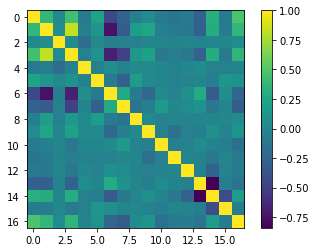

In [7]:
# correlation matrix
plt.imshow(M)
plt.colorbar()
plt.show()

In [8]:
# SVD using numpy function
U, E, VT = np.linalg.svd(M)

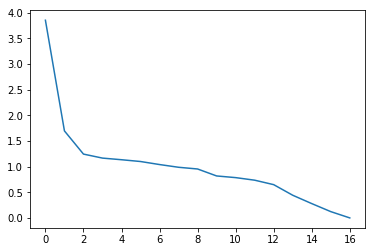

In [9]:
plt.plot(E)
plt.show()

In [10]:
P = np.dot(U[:,:2],np.diag(E[:2]))

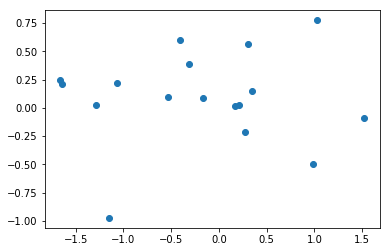

In [11]:
plt.plot(P[:,0], P[:,1],'o')
plt.show()

In [12]:
N = train.T
N.columns = N.iloc[0]
N = N.drop('ID')
N = N.astype(float)

In [13]:
# Takes 10-15 minutes with all of the data
N = N.corr()
N.head()

ID,6HlGEenccWjirZaYUfSSij,4UYmECqeFLJ8it4igTGjoU,79HDcjLmBZCUyUDlsyIzRW,7aZ2AqSnr45SqNJOIbawWn,5SkSa4KcYWKZehf5vvDN06,2IRL3XS3C90OZkGsAVB8Le,0nMU5HjUTsHNT0GyiwwOlx,6gjOa1Mmr5Jxf4kT8Zjpuj,7JpDukkoi1z0GXDoh5YN3a,4iiSu5GQLMD6Uwjw9MySaF,...,0MfggQ2U1QFGzX3iIWwRgO,0UxEiVVQuhje4Tnmw6Yijl,0jfYxmacjLYl2lciPQqaXo,2G2CCdoKsuttpaRvUCVaDy,23p3Ns2RotnKqx1TYWV0u2,0vZXYvXqtaCQI3mpz8d8dg,6KkitsdaqEJzj0btGkscEW,2tlklTstOLFLeFvfsvZOeh,7uIxMQwj9DUvNpwVtIq8zs,6ed807urNGG5dGYGLOVJxv
ID,,,,,,,,,,,,,,,,,,,,,
6HlGEenccWjirZaYUfSSij,1.000000,-0.031367,-0.267403,-0.171868,0.218559,-0.177664,0.733144,0.426155,0.297182,0.280174,...,0.789000,0.654444,-0.387774,0.464894,0.031271,0.646146,-0.028171,0.341396,0.514894,0.714822
4UYmECqeFLJ8it4igTGjoU,-0.031367,1.000000,0.198868,0.685707,0.022167,-0.198911,-0.285111,-0.344554,0.154603,-0.130503,...,0.178292,0.076028,-0.291715,-0.017670,-0.642013,-0.013719,0.050183,0.089756,0.155292,-0.249123
79HDcjLmBZCUyUDlsyIzRW,-0.267403,0.198868,1.000000,0.021255,0.197752,0.444279,-0.325095,-0.807928,-0.636172,-0.322881,...,-0.065637,-0.579428,0.561533,-0.217307,0.269835,0.106544,0.680500,-0.376131,-0.634952,-0.724747
7aZ2AqSnr45SqNJOIbawWn,-0.171868,0.685707,0.021255,1.000000,0.106655,-0.302832,-0.267326,-0.300291,-0.028196,-0.400223,...,-0.050032,-0.050593,-0.075753,0.004847,-0.533330,-0.402970,-0.371235,-0.165678,0.204466,0.029872
5SkSa4KcYWKZehf5vvDN06,0.218559,0.022167,0.197752,0.106655,1.000000,0.248151,0.324471,0.070568,-0.364664,-0.068816,...,0.421794,-0.019649,-0.125233,0.133287,0.129072,0.355128,-0.173083,-0.201429,0.366400,0.110984


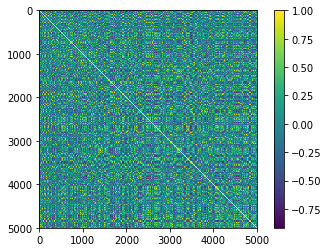

In [14]:
# Identifies how different songs correlate to each other, there is a fair amount of uniqueness among songs
plt.imshow(N)
plt.colorbar()
plt.show()

In [15]:
U, E, VT = np.linalg.svd(N)

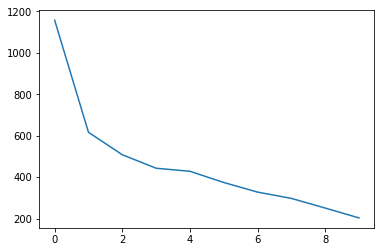

In [16]:
# Most of the variance can be explained using the first 8 or so components
plt.plot(E[:10])
plt.show()

In [17]:
P = np.dot(U[:,:2],np.diag(E[:2]))
print(P)

[[-12.10285518  16.1767484 ]
 [ -8.11837562  -1.73578676]
 [ 28.31677898  -0.46585448]
 ...
 [-15.18193517  11.68349572]
 [-23.20887622   7.71904618]
 [-21.92513932   8.01834065]]


In [19]:
# plot first two principal components to get an idea of the shape of the data
_tools_to_show = 'box_zoom,pan,save,hover,reset,tap,wheel_zoom'        
p = figure(plot_width=400, plot_height=400, title=None, tools=_tools_to_show)

# add a circle renderer with a size, color, and alpha
p.circle(P[:,0], P[:,1], size=4, color="navy", alpha=0.2)

# show the results
show(p)

In [20]:
# SVM

In [21]:
# Further divide training and testing based on principal components
# Slice U and E based on the ideal number of principal components
P = np.dot(U, np.diag(E))
X_train, X_test, y_train, y_test = train_test_split(P, train['valence'], test_size = 0.2, random_state = 0)

In [22]:
clf = svm.SVR(kernel='linear')

In [23]:
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [24]:
# testing error
y_preds = clf.predict(X_test)
MSE = np.mean((y_preds - y_test)**2)
MSE

0.05970299403910693

In [25]:
clf.score(X_test, y_test)

0.9401355225256753

In [26]:
clf.score(X_train, y_train)

0.9381459041837743

In [67]:
# training error
train_preds = clf.predict(X_train)
MSE2 = np.mean((train_preds - y_train)**2)
MSE2

0.06803473291593345

In [43]:
# Random Forest
clf = RandomForestRegressor()

# specify parameters and distributions to sample from
parameters_rand = {
    "n_estimators": sp_randint(10, 60),
    "bootstrap": [True, False],
}

# run randomized search
# Accuracy should be comparable to grid search, but runs much much faster
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=parameters_rand,
                                   n_iter=n_iter_search,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

predicted = random_search.predict(X_test)

print("PCA with random forest")
random_search.score(X_test, y_test)

PCA with random forest


0.912547369302579